# Evaluate latent time prediction via redefining global latent time

Before run this notebooks, please run `2_regvelo.ipynb`,`2_velovi.ipynb` and `2_velovi_td.ipynb` for three times to save the resulted anndata accordingly.

## Library imports

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import anndata as ad
import scanpy as sc

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import get_time_correlation

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## Constants

In [4]:
DATASET1 = "cell_cycle"
DATASET2 = "cell_cycle_rpe1"

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET2).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [5]:
VELO_METHODS = ["regvelo", "velovi", "velovi_td", "scvelo"]
custom_palette = {
    "U2OS": "#0072B2",  # Elegant blue (colorblind-friendly)
    "RPE1": "#E69F00",  # Gold-orange (also friendly and high contrast)
}
METHOD = [
    "rgv",
    "rgv_rep2",
    "rgv_rep3",
    "scv",
    "velovi",
    "velovi_rep2",
    "velovi_rep3",
    "velovi_td",
    "velovi_td_rep2",
    "velovi_td_rep3",
]

## Define functions

In [ ]:
def GlobalTimeDPTordering(adata: ad.AnnData):
    """Compute latent time using graph-based diffusion pseudotime (DPT) ordering.

    This function temporarily replaces the expression matrix with the
    fitted values, computes neighbors, diffusion maps, and diffusion
    pseudotime, and then restores the original expression matrix.

    Parameters
    ----------
    adata : ad.AnnData
        Annotated data matrix.

    Returns
    -------
    ad.AnnData
        The AnnData object with `latent_time` stored in `adata.obs`.
    """
    adata.layers["GEX"] = adata.X.copy()
    adata.X = adata.layers["fit_t"].copy()

    sc.pp.neighbors(adata, n_neighbors=30, metric="correlation", use_rep="X")
    sc.tl.diffmap(adata)

    adata.uns["iroot"] = (adata.layers["fit_t"] ** 2).mean(1).argmin()
    sc.tl.dpt(adata)

    adata.obs["latent_time"] = adata.obs["dpt_pseudotime"].copy()

    adata.X = adata.layers["GEX"].copy()
    del adata.layers["GEX"]

    return adata

## Use latent time layer to calculate neighbor graph and define global latent time

In [24]:
corr_time = []
for i in METHOD:
    adata = sc.read_h5ad(DATA_DIR / DATASET1 / "processed" / f"adata_{i}.h5ad")
    adata = GlobalTimeDPTordering(adata)
    corr_time.append(
        get_time_correlation(ground_truth=adata.obs["cell_cycle_position"], estimated=adata.obs["latent_time"])
    )

In [25]:
time_df = pd.DataFrame(
    {"method": ["regvelo"] * 3 + ["scvelo"] + ["velovi"] * 3 + ["velovi_td"] * 3, "spearman_corr": corr_time}
)

In [26]:
time_df_rpe1 = time_df.copy()
time_df_rpe1

,method,spearman_corr
0,regvelo,0.455059
1,regvelo,0.481358
2,regvelo,0.453335
3,scvelo,0.332056
4,velovi,-0.341981
5,velovi,0.645073
6,velovi,-0.381067
7,velovi_td,-0.398513
8,velovi_td,0.197365
9,velovi_td,0.305876


In [28]:
corr_time = []
for i in METHOD:
    adata = sc.read_h5ad(DATA_DIR / DATASET2 / "processed" / f"adata_{i}.h5ad")
    adata = GlobalTimeDPTordering(adata)
    corr_time.append(get_time_correlation(ground_truth=adata.obs["fucci_time"], estimated=adata.obs["latent_time"]))

In [29]:
time_df = pd.DataFrame(
    {"method": ["regvelo"] * 3 + ["scvelo"] + ["velovi"] * 3 + ["velovi_td"] * 3, "spearman_corr": corr_time}
)

In [30]:
time_df_u2os = time_df.copy()
time_df_u2os

,method,spearman_corr
0,regvelo,0.325817
1,regvelo,0.338398
2,regvelo,0.334311
3,scvelo,0.153472
4,velovi,-0.786511
5,velovi,-0.205858
6,velovi,-0.222118
7,velovi_td,0.223798
8,velovi_td,0.660562
9,velovi_td,0.288485


In [31]:
time_df_u2os["Dataset"] = "U2OS"
time_df_rpe1["Dataset"] = "RPE1"

In [32]:
time_df = pd.concat([time_df_u2os, time_df_rpe1])

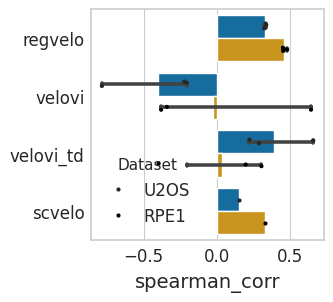

In [42]:
# Plot using the refined Cell-style palette
with mplscience.style_context():
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3), sharey=True)

    sns.barplot(
        y="method",
        x="spearman_corr",
        data=time_df,
        hue="Dataset",
        capsize=0.1,
        order=VELO_METHODS,
        ax=ax,
        palette=custom_palette,
    )

    sns.stripplot(
        y="method",
        x="spearman_corr",
        data=time_df,
        hue="Dataset",
        dodge=True,
        order=VELO_METHODS,
        size=3,
        jitter=True,
        color="black",
        ax=ax,
        linewidth=0,
    )

    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))  # remove duplicates
    ax.legend(unique.values(), unique.keys(), title="Dataset", frameon=False)

    ax.set_xlabel("spearman_corr", fontsize=14)
    ax.set_ylabel("")
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET2 / "time_compare.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()